In [1]:
import numpy as np
from utils import *
from map import OccupancyMap
from transform import *
import matplotlib.pyplot as plt
from motion import *
from observation import *
from particle import *
# from t

In [2]:
dataset = 21
root = "../data/"
joint_data, range_lim, lidar_angle_lim = GetData(root, dataset)

In [3]:
# plot map with first laser scan
pose = { 'x': 0.0, 'y': 0.0, 'theta': 0.0 }
xlim = (-30,30)
ylim = (-30,30)
T = Transform(range_lim, lidar_angle_lim)
Map = OccupancyMap(T, xlim=xlim, ylim=ylim, res=0.2)
# Map = OccupancyMap(xlim=xlim, ylim=ylim, res=0.1)

In [4]:
# dead-reckoning
robot_pose = GetOdometry(joint_data)

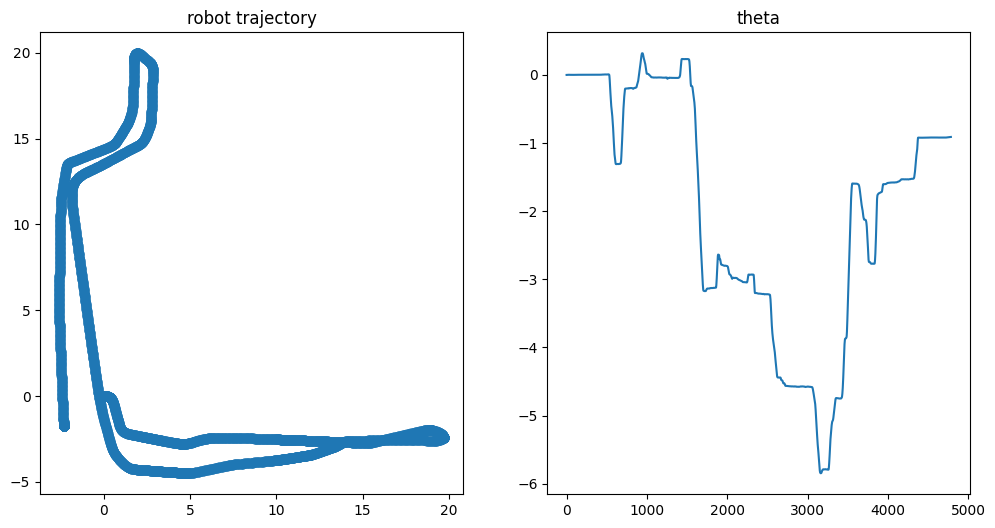

In [5]:
# plot trajectory
traj = robot_pose[:,:2]
fig = plt.figure(figsize=(12,6))

ax1 = fig.add_subplot(121)
plt.scatter(traj[:,0], traj[:,1])
plt.title("robot trajectory")

ax2 = fig.add_subplot(122)
plt.plot(robot_pose[:,2])
plt.title("theta")
plt.show()

In [ ]:
# with only deadreckoning
trajectory_dead = np.empty(shape=(1,2))
step_size = 4
for i in range(0, len(joint_data), step_size):
    if i == 0:
        continue

    data = joint_data[i]

    # Predict, get pose
    cur_pose = robot_pose[i]

    # No update
    trajectory_dead = np.vstack((trajectory_dead, [int(cur_pose[0] / Map.res) + Map.xsize // 2, int(cur_pose[1] / Map.res) + Map.ysize // 2]))

    # Mapping
    best_pose = { 'x': cur_pose[0], 'y': cur_pose[1], 'theta': cur_pose[2] }
    Map.mapping(data['lidar_ranges'], best_pose)

    if i % 100 == 0:
        print(f"Step {i}")
    # if i % 50 == 0:
        Map.plot(trajectory_dead, data, best_pose, range_lim, f"../frames_{dataset}_dead/frame_{i}.png", i)

In [91]:
GetGif(f"../frames_{dataset}_dead/", f"test_dead_{dataset}.gif")

Plot...


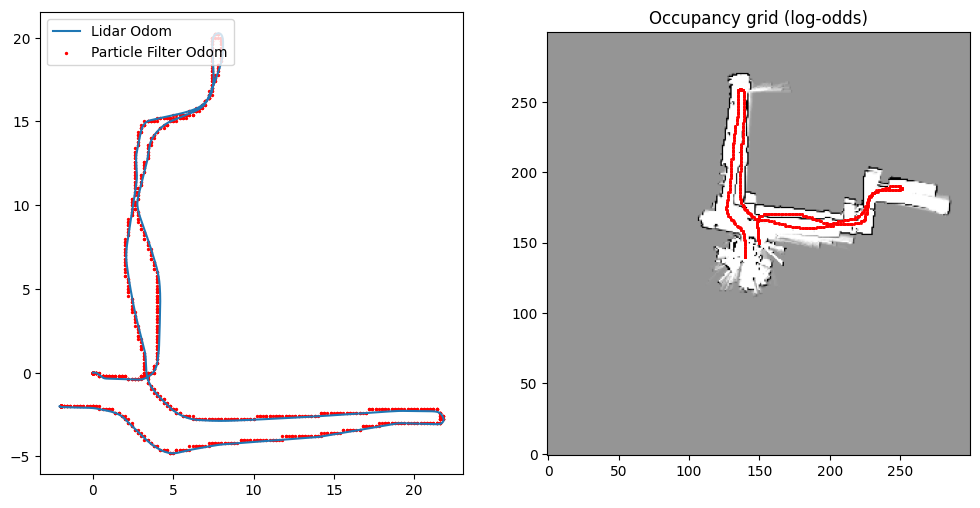

In [92]:
print("Plot...")
fig = plt.figure(figsize=(12,6))

ax1 = fig.add_subplot(121)
plt.plot(robot_pose.T[0], robot_pose.T[1], label="Lidar Odom")
plt.scatter((trajectory_dead[1:].T[0] - Map.grid.shape[0] // 2) * Map.res,
            (trajectory_dead[1:].T[1] - Map.grid.shape[1] // 2) * Map.res,
            label="Particle Filter Odom", s=2, c='r')
plt.legend(loc='upper left')

ax2 = fig.add_subplot(122)
# plt.imshow(self.grid, cmap='gray', vmin=-100, vmax=100, origin='lower')
plt.imshow(Map.grid, cmap='Greys', origin='lower')
plt.scatter(trajectory_dead[1:].T[1], trajectory_dead[1:].T[0], s=1, c='r')
plt.title("Occupancy grid (log-odds)")
plt.show()

In [6]:
# use particle filter
# plot map with first laser scan
pose = { 'x': 0.0, 'y': 0.0, 'theta': 0.0 }
xlim = (-30,30)
ylim = (-30,30)
T = Transform(range_lim, lidar_angle_lim)
Map = OccupancyMap(T, xlim=xlim, ylim=ylim, res=0.2)
# Map = OccupancyMap(xlim=xlim, ylim=ylim, res=0.1)

num_particle = 200
P = Particle(num=num_particle)
# noise for motion model
# noise_var_scale = np.array([0.001, 0.001, 0.1*np.pi/180])
# noise_var_scale = np.array([0.01, 0.01, 0.1*np.pi/180])
# x_sigma = 1e-4 * 2, 1e-4 * 5 (200, use norm)
# y_sigma = 1e-4 * 2, 1e-4 * 5
# omega_sigma = 1e-5 * 2, 1e-5 * 1
x_sigma = 1e-4 * 5
y_sigma = 1e-4 * 5
omega_sigma = 1e-5 * 1
noise_var_scale = np.diag([x_sigma, y_sigma, omega_sigma])
# noise_var_scale = np.array([x_sigma, y_sigma, omega_sigma])
trajectory = np.empty(shape=(1,2))

In [ ]:
step_size = 4
# for i, data in enumerate(0, joint_data, step_size):
for i in range(0, len(joint_data), step_size):
    if i == 0:
        continue

    data = joint_data[i]

    # Predict
    # delta_pose = robot_pose[i] - robot_pose[i-1]
    delta_pose = GetRelativeMotion(robot_pose, i, step_size)
    P.state = MotionModelPrediction(P.state , delta_pose, noise_var_scale)

    # Update
    # best_particle = UpdateParticle(Map, P, data['lidar_ranges'], range_lim)
    best_particle = UpdateParticle(Map, P, data['lidar_ranges'], T)
    trajectory = np.vstack((trajectory, [int(best_particle[0] / Map.res) + Map.xsize // 2, int(best_particle[1] / Map.res) + Map.ysize // 2]))

    # Mapping
    best_pose = { 'x': best_particle[0], 'y': best_particle[1], 'theta': best_particle[2] }
    Map.mapping(data['lidar_ranges'], best_pose)

    # Resample
    N_eff = 1 / np.sum(P.weight ** 2)
    if N_eff < 0.1 * P.num:
        print("Resampling...")
        P.resampling()
    
    if i % 100 == 0:
        print(f"Step {i}")
    # if i % 50 == 0:
        Map.plot(trajectory, data, best_pose, f"../frames_{dataset}/frame_{i}.png", i)

In [18]:
GetGif(f"../frames_{dataset}/", f"../gif/test_{dataset}.gif")

Plot...


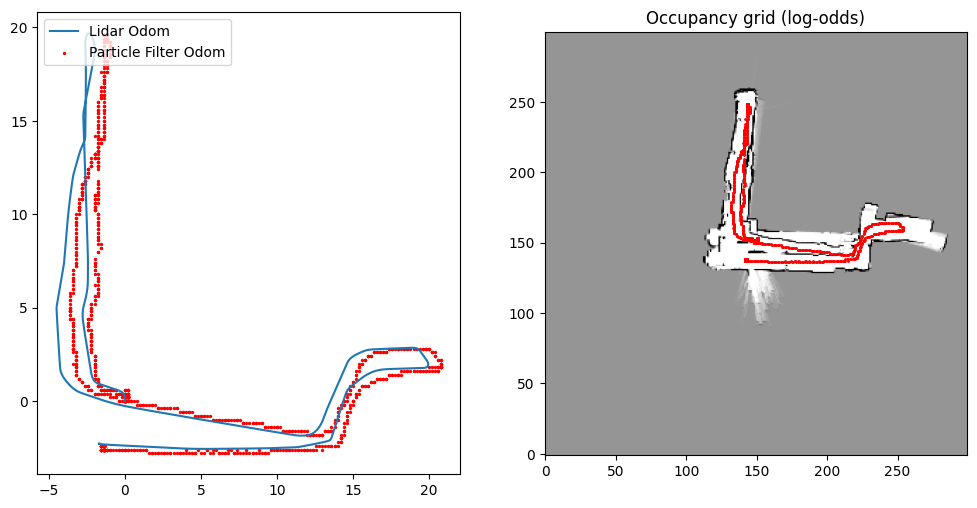

In [17]:
print("Plot...")
fig = plt.figure(figsize=(12,6))

ax1 = fig.add_subplot(121)
# plt.plot(robot_pose.T[0], robot_pose.T[1], label="Lidar Odom")
# plt.scatter((trajectory[1:].T[0] - Map.grid.shape[0] // 2) * Map.res,
#             (trajectory[1:].T[1] - Map.grid.shape[1] // 2) * Map.res,
#             label="Particle Filter Odom", s=2, c='r')
plt.plot(robot_pose.T[1], robot_pose.T[0], label="Lidar Odom")
plt.scatter((trajectory[1:].T[1] - Map.grid.shape[1] // 2) * Map.res,
            (trajectory[1:].T[0] - Map.grid.shape[0] // 2) * Map.res,
            label="Particle Filter Odom", s=2, c='r')
plt.legend(loc='upper left')

ax2 = fig.add_subplot(122)
plt.imshow(Map.grid, cmap='Greys', origin='lower')
plt.scatter(trajectory[1:].T[1], trajectory[1:].T[0], s=1, c='r')
plt.title("Occupancy grid (log-odds)")
plt.show()